In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from sklearn.metrics import classification_report, confusion_matrix
from data import SignLanguageDataset, SignLanguageDatasetCached

sys.path.append('.')
from config.config import load_config

In [2]:
class LSTMClassifier(nn.Module):
    """LSTM-based classifier for sign language sequences."""
    
    def __init__(self, input_dim=126, hidden_dim=256, num_layers=2, 
                 num_classes=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        
        context = torch.sum(attn_weights * lstm_out, dim=1)

        output = self.fc(context)
        return output


class TransformerClassifier(nn.Module):
    """Transformer-based classifier for sign language sequences."""
    
    def __init__(self, input_dim=126, d_model=256, nhead=8, 
                 num_layers=3, num_classes=2, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        
        self.input_projection = nn.Linear(input_dim, d_model)
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)

        x = torch.mean(x, dim=1)
        
        return self.classifier(x)


class PositionalEncoding(nn.Module):
    """Positional encoding for transformer."""
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [3]:
class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = config.get_device()
        
        self.train_dataset = SignLanguageDataset('data/splits/train.csv')
        self.val_dataset = SignLanguageDataset('data/splits/val.csv')
        self.test_dataset = SignLanguageDataset('data/splits/test.csv')
        
        # Create dataloaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config.training.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config.training.batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=config.training.batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        # Create model
        if config.model.model_type == 'lstm':
            self.model = LSTMClassifier(
                input_dim=126,
                hidden_dim=config.model.hidden_dim,
                num_layers=config.model.num_layers,
                num_classes=2,
                dropout=config.model.dropout
            ).to(self.device)
        elif config.model.model_type == 'transformer':
            self.model = TransformerClassifier(
                input_dim=126,
                d_model=config.model.hidden_dim,
                nhead=8,
                num_layers=config.model.num_layers,
                num_classes=2,
                dropout=config.model.dropout
            ).to(self.device)
        else:
            raise ValueError(f"Unknown model type: {config.model.model_type}")
        
        # Calculate class weights for imbalanced data
        yes_count = len(self.train_dataset.data[self.train_dataset.data['label'] == 1])
        no_count = len(self.train_dataset.data[self.train_dataset.data['label'] == 0])
        total = yes_count + no_count
        
        weight_yes = total / (2 * yes_count)
        weight_no = total / (2 * no_count)
        class_weights = torch.tensor([weight_no, weight_yes]).to(self.device)
        
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        if config.training.optimizer == 'adam':
            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay
            )
        elif config.training.optimizer == 'sgd':
            self.optimizer = optim.SGD(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay,
                momentum=0.9
            )
        elif config.training.optimizer == 'adamw':
            self.optimizer = optim.AdamW(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay
            )
        
        # Learning rate scheduler
        if config.training.scheduler == 'cosine':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config.training.epochs
            )
        elif config.training.scheduler == 'step':
            self.scheduler = optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=config.training.scheduler_step_size,
                gamma=config.training.scheduler_gamma
            )
        elif config.training.scheduler == 'plateau':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=config.training.scheduler_patience,
                factor=config.training.scheduler_gamma
            )
        else:
            self.scheduler = None
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        self.best_val_acc = 0.0
        self.early_stop_counter = 0
        
        # Create directories
        config.create_directories()
        
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for sequences, labels in pbar:
            sequences = sequences.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if self.config.training.gradient_clip:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config.training.gradient_clip
                )
            
            self.optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in tqdm(self.val_loader, desc='Validation'):
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels in tqdm(self.test_loader, desc='Testing'):
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        
        # Calculate per-class accuracy
        from sklearn.metrics import classification_report, confusion_matrix
        
        print("\nTest Results:")
        print(f"Overall Accuracy: {accuracy:.2f}%")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                   target_names=['NO', 'YES']))
        print("\nConfusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))
        
        return accuracy
    
    def train(self):
        print(f"Training on device: {self.device}")
        print(f"Model: {self.config.model.model_type}")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Val samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        
        for epoch in range(self.config.training.epochs):
            print(f"\nEpoch {epoch + 1}/{self.config.training.epochs}")
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Learning rate scheduling
            if self.scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.early_stop_counter = 0
                
                checkpoint_path = self.config.get_checkpoint_path(is_best=True)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'config': self.config.model_dump()
                }, checkpoint_path)
                print(f"✓ Saved best model (val_acc: {val_acc:.2f}%)")
            else:
                self.early_stop_counter += 1
            
            # Early stopping
            if self.early_stop_counter >= self.config.training.early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
            
            # Save checkpoint periodically
            if (epoch + 1) % self.config.logging.checkpoint_interval == 0:
                checkpoint_path = self.config.get_checkpoint_path(epoch=epoch + 1)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc
                }, checkpoint_path)
        
        # Load best model and test
        print("\nLoading best model for testing...")
        best_checkpoint = torch.load(self.config.get_checkpoint_path(is_best=True))
        self.model.load_state_dict(best_checkpoint['model_state_dict'])
        
        test_acc = self.test()
        
        # Plot training curves
        self.plot_training_curves()
        
        return test_acc
    
    def plot_training_curves(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Acc')
        ax2.plot(self.history['val_acc'], label='Val Acc')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'{self.config.logging.results_dir}/training_curves.png')
        print(f"Training curves saved to {self.config.logging.results_dir}/training_curves.png")

In [8]:
class Trainer:
    def __init__(self, config, use_cache=True, fn_penalty_factor=3.0):
        """
        Args:
            config: Configuration object
            use_cache: Whether to use cached dataset
            fn_penalty_factor: Factor to penalize false negatives (higher = more penalty)
                             1.0 = balanced, 2.0 = double penalty, 3.0 = triple penalty
        """
        self.config = config
        self.device = config.get_device()
        self.fn_penalty_factor = fn_penalty_factor
        
        # Use cached dataset for faster training
        DatasetClass = SignLanguageDatasetCached if use_cache else SignLanguageDataset
        
        # Create datasets
        self.train_dataset = DatasetClass('data/splits/train.csv')
        self.val_dataset = DatasetClass('data/splits/val.csv')
        self.test_dataset = DatasetClass('data/splits/test.csv')
        
        # Create dataloaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config.training.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config.training.batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=config.training.batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
            pin_memory=config.data.pin_memory
        )
        
        # Create model
        if config.model.model_type == 'lstm':
            self.model = LSTMClassifier(
                input_dim=126,
                hidden_dim=config.model.hidden_dim,
                num_layers=config.model.num_layers,
                num_classes=2,
                dropout=config.model.dropout
            ).to(self.device)
        elif config.model.model_type == 'transformer':
            self.model = TransformerClassifier(
                input_dim=126,
                d_model=config.model.hidden_dim,
                nhead=8,
                num_layers=config.model.num_layers,
                num_classes=2,
                dropout=config.model.dropout
            ).to(self.device)
        else:
            raise ValueError(f"Unknown model type: {config.model.model_type}")
        
        yes_count = len([l for l in self.train_dataset.labels if l == 1])
        no_count = len([l for l in self.train_dataset.labels if l == 0])
        total = yes_count + no_count
        
        # Standard balanced weights
        weight_yes_base = total / (2 * yes_count)
        weight_no_base = total / (2 * no_count)
        
        # Apply penalty factor to YES class (increase weight = penalize missing YES more)
        weight_yes = weight_yes_base * fn_penalty_factor
        weight_no = weight_no_base
        
        class_weights = torch.tensor([weight_no, weight_yes]).to(self.device)
        
        print(f"\n{'='*60}")
        print(f"Class Distribution:")
        print(f"  NO samples: {no_count} ({100*no_count/total:.1f}%)")
        print(f"  YES samples: {yes_count} ({100*yes_count/total:.1f}%)")
        print(f"\nClass Weights (FN Penalty Factor: {fn_penalty_factor}x):")
        print(f"  NO weight: {weight_no:.3f}")
        print(f"  YES weight: {weight_yes:.3f} (penalizes false negatives)")
        print(f"{'='*60}\n")
        
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        if config.training.optimizer == 'adam':
            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay
            )
        elif config.training.optimizer == 'sgd':
            self.optimizer = optim.SGD(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay,
                momentum=0.9
            )
        elif config.training.optimizer == 'adamw':
            self.optimizer = optim.AdamW(
                self.model.parameters(),
                lr=config.training.learning_rate,
                weight_decay=config.training.weight_decay
            )
        
        if config.training.scheduler == 'cosine':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config.training.epochs
            )
        elif config.training.scheduler == 'step':
            self.scheduler = optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=config.training.scheduler_step_size,
                gamma=config.training.scheduler_gamma
            )
        elif config.training.scheduler == 'plateau':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=config.training.scheduler_patience,
                factor=config.training.scheduler_gamma
            )
        else:
            self.scheduler = None
        
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_recall_yes': [],
            'val_precision_yes': []
        }
        
        self.best_val_recall = 0.0
        self.early_stop_counter = 0

        self.best_val_acc = 0.0
        self.early_stop_counter = 0
        
        # Create directories
        config.create_directories()
        
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for sequences, labels in pbar:
            sequences = sequences.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            
            if self.config.training.gradient_clip:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.config.training.gradient_clip
                )
            
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels in tqdm(self.val_loader, desc='Validation', leave=False):
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100 * correct / total
        
        # Calculate recall and precision for YES class (class 1)
        from sklearn.metrics import recall_score, precision_score
        recall_yes = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
        precision_yes = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
        
        return epoch_loss, epoch_acc, recall_yes, precision_yes
    
    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels in tqdm(self.test_loader, desc='Testing'):
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        
        from sklearn.metrics import recall_score
        
        # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        recall_yes = recall_score(all_labels, all_preds, pos_label=1)
        
        print("\n" + "="*60)
        print("Test Results:")
        print("="*60)
        print(f"Overall Accuracy: {accuracy:.2f}%")
        print(f"\n⚠️  Critical Metrics (False Negative Penalty):")
        print(f"  YES Recall (Sensitivity): {recall_yes*100:.2f}% ← Higher is better!")
        print(f"  False Negatives: {fn} (missing YES predictions)")
        print(f"  False Positives: {fp} (acceptable)")
        print(f"\nDetailed Breakdown:")
        print(f"  True Positives (TP):  {tp}")
        print(f"  True Negatives (TN):  {tn}")
        print(f"  False Positives (FP): {fp} ✓ acceptable")
        print(f"  False Negatives (FN): {fn} ✗ penalized")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                   target_names=['NO', 'YES']))
        print("\nConfusion Matrix:")
        print("              Predicted")
        print("              NO   YES")
        print(f"Actual NO   [{tn:4d} {fp:4d}]")
        print(f"       YES  [{fn:4d} {tp:4d}]  ← FN should be low!")
        print("="*60)
        
        return accuracy, recall_yes
    
    def train_model(self):
        print("="*60)
        print(f"Training Configuration")
        print("="*60)
        print(f"Device: {self.device}")
        print(f"Model: {self.config.model.model_type}")
        print(f"Train samples: {len(self.train_dataset)}")
        print(f"Val samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        print(f"Batch size: {self.config.training.batch_size}")
        print(f"Epochs: {self.config.training.epochs}")
        print(f"Learning rate: {self.config.training.learning_rate}")
        print(f"Optimizer: {self.config.training.optimizer}")
        print(f"FN Penalty Factor: {self.fn_penalty_factor}x")
        print("="*60 + "\n")
        
        for epoch in range(self.config.training.epochs):
            print(f"\nEpoch {epoch + 1}/{self.config.training.epochs}")
            print("-" * 60)
            
            train_loss, train_acc = self.train_epoch()
            
            val_loss, val_acc, val_recall_yes, val_precision_yes = self.validate()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_recall_yes'].append(val_recall_yes)
            self.history['val_precision_yes'].append(val_precision_yes)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Val YES Recall: {val_recall_yes*100:.2f}%, Precision: {val_precision_yes*100:.2f}%")
            
            if self.scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
                print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Save best model based on YES recall (not accuracy)
            if val_recall_yes > self.best_val_recall:
                self.best_val_recall = val_recall_yes
                self.early_stop_counter = 0
                
                checkpoint_path = self.config.get_checkpoint_path(is_best=True)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_recall_yes': val_recall_yes,
                    'config': self.config.model_dump()
                }, checkpoint_path)
                print(f"✓ Saved best model (YES recall: {val_recall_yes*100:.2f}%)")
            else:
                self.early_stop_counter += 1
                print(f"Early stop counter: {self.early_stop_counter}/{self.config.training.early_stopping_patience}")

            # # Accuracy as main metric
            # if val_acc > self.best_val_acc:
            #     self.best_val_acc = val_acc
            #     self.early_stop_counter = 0

            #     checkpoint_path = self.config.get_checkpoint_path(is_best=True)
            #     torch.save({
            #         'epoch': epoch,
            #         'model_state_dict': self.model.state_dict(),
            #         'optimizer_state_dict': self.optimizer.state_dict(),
            #         'val_acc': val_acc,
            #         'val_recall_yes': val_recall_yes,  # optional: keep for reporting
            #         'config': self.config.model_dump()
            #     }, checkpoint_path)
            #     print(f"✓ Saved best model (val_acc: {val_acc:.2f}%)")
            # else:
            #     self.early_stop_counter += 1
            #     print(f"Early stop counter: {self.early_stop_counter}/{self.config.training.early_stopping_patience}")
            
            if self.early_stop_counter >= self.config.training.early_stopping_patience:
                print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
                break
            
            if (epoch + 1) % self.config.logging.checkpoint_interval == 0:
                checkpoint_path = self.config.get_checkpoint_path(epoch=epoch + 1)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_recall_yes': val_recall_yes
                }, checkpoint_path)
                print(f"✓ Saved checkpoint at epoch {epoch + 1}")
        
        print("\n" + "="*60)
        print("Loading best model for testing...")
        print("="*60)
        best_checkpoint = torch.load(self.config.get_checkpoint_path(is_best=True))
        self.model.load_state_dict(best_checkpoint['model_state_dict'])
        print(f"Best model from epoch {best_checkpoint['epoch'] + 1} loaded")
        # print(f"Best validation Accuracy: {best_checkpoint.get('val_acc', 0):.2f}%")
        print(f"Best validation YES recall: {best_checkpoint.get('val_recall_yes', 0)*100:.2f}%")
        
        test_acc, test_recall_yes = self.test()
        
        self.plot_training_curves()
        
        return test_acc, test_recall_yes
    
    def plot_training_curves(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        ax1.plot(self.history['train_loss'], label='Train Loss', marker='o')
        ax1.plot(self.history['val_loss'], label='Val Loss', marker='s')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy
        ax2.plot(self.history['train_acc'], label='Train Acc', marker='o')
        ax2.plot(self.history['val_acc'], label='Val Acc', marker='s')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # YES Class Recall (Most Important!)
        ax3.plot([r*100 for r in self.history['val_recall_yes']], 
                label='YES Recall', marker='o', color='green', linewidth=2)
        ax3.axhline(y=90, color='r', linestyle='--', label='90% Target')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Recall (%)')
        ax3.set_title('YES Class Recall (Minimize False Negatives)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # YES Class Precision
        ax4.plot([p*100 for p in self.history['val_precision_yes']], 
                label='YES Precision', marker='s', color='blue')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Precision (%)')
        ax4.set_title('YES Class Precision')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        save_path = f'{self.config.logging.results_dir}/training_curves.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Training curves saved to {save_path}")
        plt.show()

In [9]:
config = load_config("config/config.yaml")
config.print_config()

Sign Language Detector Configuration: sl_binary_classifier

Preprocessing:
----------------------------------------
  frames_per_second: 5
  max_frames_per_video: 37
  trim_start_portion: 0.15
  trim_end_portion: 0.85

Model:
----------------------------------------
  model_type: lstm
  num_classes: 2
  hidden_dim: 256
  num_layers: 2
  dropout: 0.3

Data:
----------------------------------------
  dataset_name: sign_language_binary
  data_root: ./data
  train_split: 0.8
  val_split: 0.1
  test_split: 0.1
  num_workers: 0
  pin_memory: True

Augmentation:
----------------------------------------
  use_augmentation: False
  random_horizontal_flip: False
  rotation_degrees: 0

Training:
----------------------------------------
  batch_size: 32
  epochs: 50
  learning_rate: 0.001
  weight_decay: 0.0001
  optimizer: adam
  scheduler: cosine
  scheduler_patience: 5
  scheduler_step_size: 10
  scheduler_gamma: 0.1
  gradient_clip: 1.0
  early_stopping_patience: 10

Device:
------------------

In [10]:
# Initialize trainer with FN penalty
# fn_penalty_factor: 1.0=balanced, 2.0=double penalty (recommended), 3.0=triple, 5.0=very aggressive
trainer = Trainer(config, use_cache=True, fn_penalty_factor=2.0)
print(f"\n✓ Trainer initialized successfully!")
print(f"Model parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")

Preloading 5108 sequences into memory...


Loading data: 100%|██████████| 5108/5108 [00:01<00:00, 3801.56it/s]


✓ Loaded 5108 sequences into memory
Preloading 639 sequences into memory...


Loading data: 100%|██████████| 639/639 [00:00<00:00, 3815.39it/s]


✓ Loaded 639 sequences into memory
Preloading 639 sequences into memory...


Loading data: 100%|██████████| 639/639 [00:00<00:00, 3760.20it/s]


✓ Loaded 639 sequences into memory

Class Distribution:
  NO samples: 4974 (97.4%)
  YES samples: 134 (2.6%)

Class Weights (FN Penalty Factor: 2.0x):
  NO weight: 0.513
  YES weight: 38.119 (penalizes false negatives)


✓ Trainer initialized successfully!
Model parameters: 2,495,747


Training Configuration
Device: cuda:0
Model: lstm
Train samples: 5108
Val samples: 639
Test samples: 639
Batch size: 32
Epochs: 50
Learning rate: 0.001
Optimizer: adam
FN Penalty Factor: 2.0x


Epoch 1/50
------------------------------------------------------------


Train Loss: 1.0129, Train Acc: 81.44%
Val Loss: 0.6342, Val Acc: 86.07%
Val YES Recall: 64.71%, Precision: 11.70%
Learning Rate: 0.000999
✓ Saved best model (YES recall: 64.71%)

Epoch 2/50
------------------------------------------------------------


Train Loss: 0.7733, Train Acc: 84.53%
Val Loss: 0.7871, Val Acc: 87.01%
Val YES Recall: 52.94%, Precision: 10.71%
Learning Rate: 0.000996
Early stop counter: 1/10

Epoch 3/50
------------------------------------------------------------


Train Loss: 0.5923, Train Acc: 85.73%
Val Loss: 0.6544, Val Acc: 88.11%
Val YES Recall: 58.82%, Precision: 12.66%
Learning Rate: 0.000991
Early stop counter: 2/10

Epoch 4/50
------------------------------------------------------------


Train Loss: 0.5026, Train Acc: 84.51%
Val Loss: 0.5951, Val Acc: 86.38%
Val YES Recall: 64.71%, Precision: 11.96%
Learning Rate: 0.000984
Early stop counter: 3/10

Epoch 5/50
------------------------------------------------------------


Train Loss: 0.4840, Train Acc: 84.93%
Val Loss: 0.4223, Val Acc: 73.71%
Val YES Recall: 88.24%, Precision: 8.29%
Learning Rate: 0.000976
✓ Saved best model (YES recall: 88.24%)
✓ Saved checkpoint at epoch 5

Epoch 6/50
------------------------------------------------------------


Train Loss: 0.4789, Train Acc: 86.88%
Val Loss: 0.5277, Val Acc: 84.35%
Val YES Recall: 64.71%, Precision: 10.48%
Learning Rate: 0.000965
Early stop counter: 1/10

Epoch 7/50
------------------------------------------------------------


Train Loss: 0.5568, Train Acc: 87.55%
Val Loss: 0.6118, Val Acc: 90.61%
Val YES Recall: 64.71%, Precision: 16.92%
Learning Rate: 0.000952
Early stop counter: 2/10

Epoch 8/50
------------------------------------------------------------


Train Loss: 0.4524, Train Acc: 89.25%
Val Loss: 0.4345, Val Acc: 87.79%
Val YES Recall: 70.59%, Precision: 14.12%
Learning Rate: 0.000938
Early stop counter: 3/10

Epoch 9/50
------------------------------------------------------------


Train Loss: 0.3811, Train Acc: 90.31%
Val Loss: 0.4760, Val Acc: 89.20%
Val YES Recall: 70.59%, Precision: 15.79%
Learning Rate: 0.000922
Early stop counter: 4/10

Epoch 10/50
------------------------------------------------------------


Train Loss: 0.4481, Train Acc: 90.99%
Val Loss: 0.6304, Val Acc: 94.68%
Val YES Recall: 47.06%, Precision: 24.24%
Learning Rate: 0.000905
Early stop counter: 5/10
✓ Saved checkpoint at epoch 10

Epoch 11/50
------------------------------------------------------------


Train Loss: 0.3374, Train Acc: 92.56%
Val Loss: 0.3778, Val Acc: 92.64%
Val YES Recall: 70.59%, Precision: 22.22%
Learning Rate: 0.000885
Early stop counter: 6/10

Epoch 12/50
------------------------------------------------------------


Train Loss: 0.3429, Train Acc: 94.19%
Val Loss: 1.2201, Val Acc: 96.56%
Val YES Recall: 17.65%, Precision: 27.27%
Learning Rate: 0.000864
Early stop counter: 7/10

Epoch 13/50
------------------------------------------------------------


Train Loss: 0.3084, Train Acc: 94.87%
Val Loss: 0.9794, Val Acc: 96.71%
Val YES Recall: 23.53%, Precision: 33.33%
Learning Rate: 0.000842
Early stop counter: 8/10

Epoch 14/50
------------------------------------------------------------


Train Loss: 0.3899, Train Acc: 95.20%
Val Loss: 0.5296, Val Acc: 95.46%
Val YES Recall: 58.82%, Precision: 31.25%
Learning Rate: 0.000819
Early stop counter: 9/10

Epoch 15/50
------------------------------------------------------------


Train Loss: 0.3825, Train Acc: 96.77%
Val Loss: 0.9046, Val Acc: 97.34%
Val YES Recall: 29.41%, Precision: 50.00%
Learning Rate: 0.000794
Early stop counter: 10/10

⚠ Early stopping triggered after 15 epochs

Loading best model for testing...
Best model from epoch 5 loaded
Best validation YES recall: 88.24%


Testing: 100%|██████████| 20/20 [00:00<00:00, 179.99it/s]


Test Results:
Overall Accuracy: 74.80%

⚠️  Critical Metrics (False Negative Penalty):
  YES Recall (Sensitivity): 94.12% ← Higher is better!
  False Negatives: 1 (missing YES predictions)
  False Positives: 160 (acceptable)

Detailed Breakdown:
  True Positives (TP):  16
  True Negatives (TN):  462
  False Positives (FP): 160 ✓ acceptable
  False Negatives (FN): 1 ✗ penalized

Classification Report:
              precision    recall  f1-score   support

          NO       1.00      0.74      0.85       622
         YES       0.09      0.94      0.17        17

    accuracy                           0.75       639
   macro avg       0.54      0.84      0.51       639
weighted avg       0.97      0.75      0.83       639


Confusion Matrix:
              Predicted
              NO   YES
Actual NO   [ 462  160]
       YES  [   1   16]  ← FN should be low!



✓ Training curves saved to ./results/training_curves.png


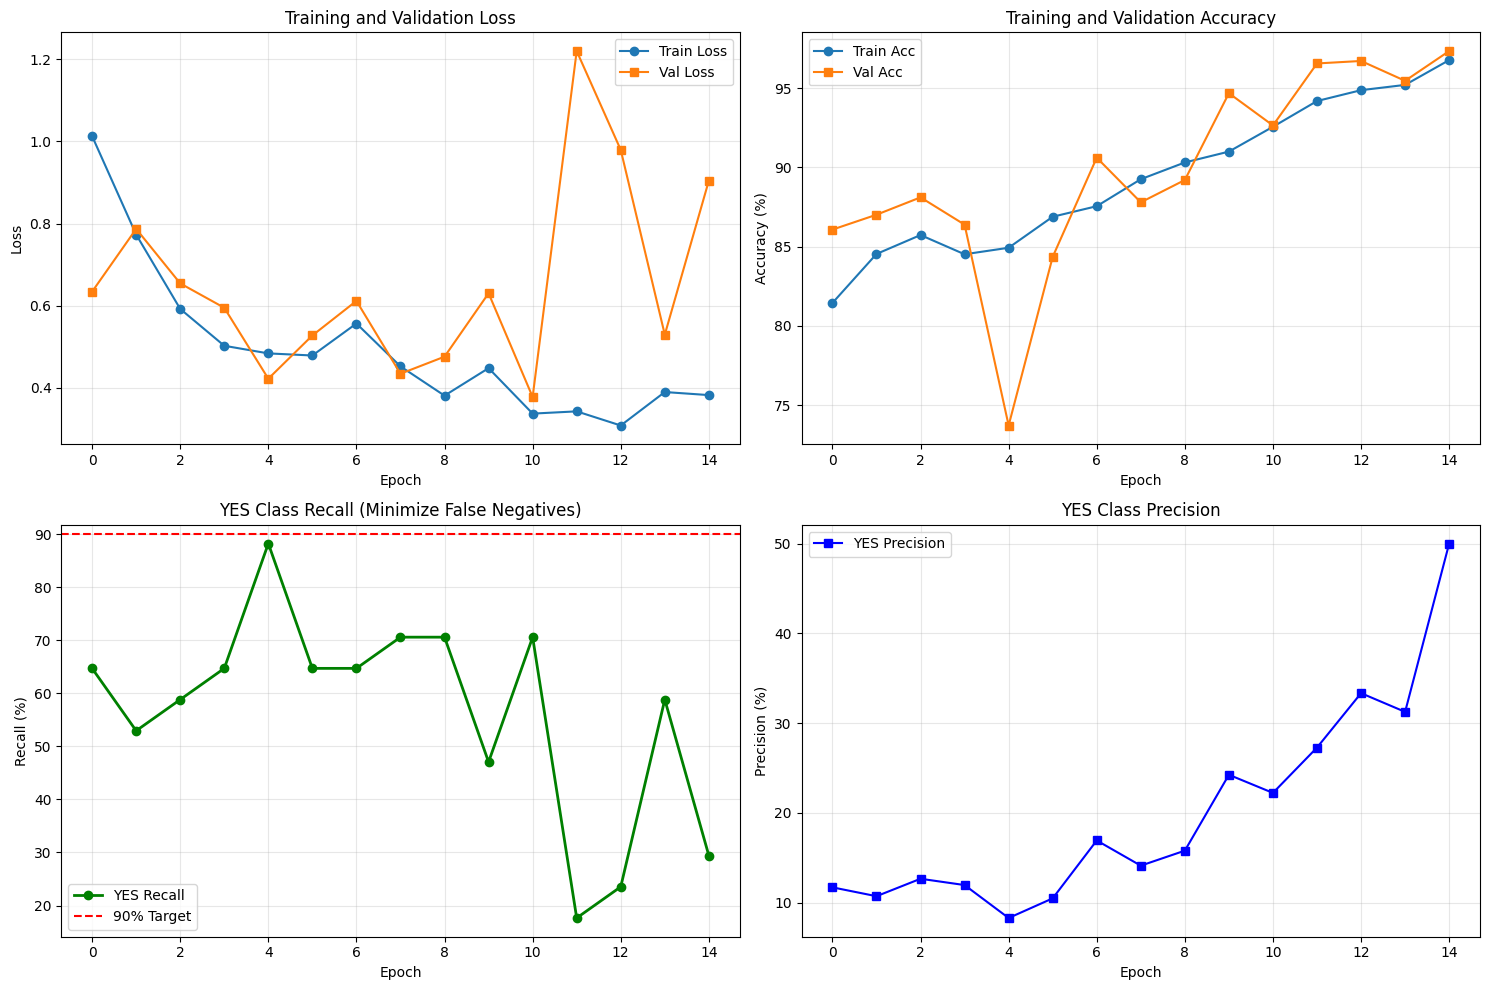


🎉 Training Complete!
Final Test Accuracy: 74.80%
YES Class Recall: 94.12% ← Key metric!
Best Val YES Recall: 88.24%


In [11]:
test_acc, test_recall = trainer.train_model()
print(f"\n{'='*60}")
print(f"🎉 Training Complete!")
print(f"{'='*60}")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"YES Class Recall: {test_recall*100:.2f}% ← Key metric!")
print(f"Best Val YES Recall: {trainer.best_val_recall*100:.2f}%")
print(f"{'='*60}")